### Test2

In [1]:
print("a")

a


1. 関数定義

In [19]:
# ================================
# Cell 1 — 関数定義（IO・前処理・QRC・学習器・評価/可視化）
# ================================
import os, re, time, math, pathlib
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# ---------- Timer / IO ----------
class Timer:
    def __init__(self, label=""): self.label = label
    def __enter__(self): self.t0 = time.perf_counter(); return self
    def __exit__(self, *exc): 
        dt = time.perf_counter() - self.t0
        if self.label: print(f"[TIMER] {self.label}: {dt:.2f}s")

def rmse_(y_true, y_pred):
    # sklearn <= 0.22 互換
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def ensure_outdir():
    win_dir = r"C:\qiskit-python\QFF2025\outputs\QRC"
    posix_dir = "./outputs/QRC"
    outdir = win_dir if os.name == "nt" else posix_dir
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    print(f"[IO] Export directory = {outdir}")
    return outdir

def savefig(path, dpi=300):
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[SAVE] {path}")
    plt.show()

def save_table(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False)
    print(f"[SAVE] {path}")

# ---------- CSV 読み込み（Date検出・数値化・観測マスク） ----------
HEADER_BIPAT = r"Tenor\s*:\s*([0-9.+\-eE]+)\s*;\s*Maturity\s*:\s*([0-9.+\-eE]+)"
TENOR_PAT   = r"Tenor\s*:\s*([0-9.+\-eE]+)(?=\s*;)"
MATU_PAT    = r"Maturity\s*:\s*([0-9.+\-eE]+)"

def read_swaption_csv_with_mask(csv_path: str):
    df = pd.read_csv(csv_path, engine="python", sep=None)
    date_col = None
    for c in df.columns[::-1]:
        if str(c).strip().lower() == "date":
            date_col = c; break
    if date_col is None: date_col = df.columns[-1]
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    feature_cols = [c for c in df.columns if c != date_col]
    df_num = df.copy()
    df_num[feature_cols] = df_num[feature_cols].apply(pd.to_numeric, errors="coerce")
    mask_obs = ~df_num[feature_cols].isna().values
    df_filled = df_num.copy()
    df_filled[feature_cols] = df_filled[feature_cols].ffill().bfill()
    return df_filled, date_col, feature_cols, mask_obs

# ---------- Tenor/Maturity 解析と因子基底 Φ(1,T,M,T2,M2,TxM) ----------
def parse_tenor_maturity_from_headers(cols: List[str]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    T_list, M_list, bad = [], [], []
    for c in cols:
        s = str(c)
        m = re.search(HEADER_BIPAT, s)
        if m:
            t = float(m.group(1).strip(" ,;"))
            u = float(m.group(2).strip(" ,;"))
        else:
            m1 = re.search(TENOR_PAT, s); m2 = re.search(MATU_PAT, s)
            if m1 and m2:
                t = float(m1.group(1).strip(" ,;"))
                u = float(m2.group(1).strip(" ,;"))
            else:
                nums = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
                if len(nums) >= 2:
                    t, u = float(nums[0]), float(nums[1])
                else:
                    t, u = np.nan, np.nan; bad.append(s)
        T_list.append(t); M_list.append(u)
    if bad:
        print(f"[WARN] Tenor/Maturity parse failed for {len(bad)} cols (showing up to 3): {bad[:3]}")
    return np.array(T_list, float), np.array(M_list, float), np.arange(len(cols))

def _normalize_pm1(x: np.ndarray):
    x = np.asarray(x, float)
    mn, mx = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn: return np.zeros_like(x)
    return 2.0*(x - mn)/(mx - mn) - 1.0

def build_phi_poly2(tenors: np.ndarray, maturities: np.ndarray, include_cross=True):
    Tn = _normalize_pm1(tenors); Mn = _normalize_pm1(maturities)
    parts = [np.ones_like(Tn), Tn, Mn, Tn**2, Mn**2]
    names = ["1", "T", "M", "T2", "M2"]
    if include_cross: parts.append(Tn*Mn); names.append("TxM")
    Phi = np.vstack(parts).T  # (F, K)
    Phi[~np.isfinite(Phi)] = 0.0
    return Phi, names

def pinv_colwise(Phi: np.ndarray) -> np.ndarray:
    return np.linalg.pinv(Phi)  # (K, F)

def project_to_beta(X_scaled_all: np.ndarray, A: np.ndarray) -> np.ndarray:
    # (T,F) x (F,K)^T -> (T,K)
    return X_scaled_all @ A.T

def reconstruct_from_beta(beta_like: np.ndarray, Phi: np.ndarray) -> np.ndarray:
    shp = beta_like.shape
    K = Phi.shape[1]
    b2 = beta_like.reshape(-1, K) @ Phi.T
    F = Phi.shape[0]
    return b2.reshape(*(shp[:-1]), F)

# ---------- スケーラ / PCA / ウィンドウ ----------
def fit_scaler(X_all: np.ndarray, cut_train_end: int):
    scaler = StandardScaler().fit(X_all[:cut_train_end])
    X_scaled_all = scaler.transform(X_all)
    return scaler, X_scaled_all

def fit_pca_for_beta(beta_all: np.ndarray, cut_train_end: int, n_qubits: int):
    # PCA の次元は n_qubits に揃える（上限は学習サンプル-1）
    n_components_eff = min(n_qubits, beta_all.shape[1], max(1, beta_all[:cut_train_end].shape[0]-1))
    pca = PCA(n_components=n_components_eff, random_state=42).fit(beta_all[:cut_train_end])
    B_reduced_all = pca.transform(beta_all)
    return pca, B_reduced_all

def make_windows(X_any_all: np.ndarray, W: int) -> np.ndarray:
    out = []
    for t in range(W, len(X_any_all)):
        out.append(X_any_all[t-W:t])
    return np.asarray(out, float)  # (T-W, W, dim)

# ---------- 目的（β空間の Δ or level） ----------
def build_targets_beta(beta_all: np.ndarray, W: int, H: int, target_mode="delta"):
    T, K = beta_all.shape
    idx = []; Ys = []; bases = []
    for t in range(W, T - H):
        base = beta_all[t]
        ys = []
        for h in range(1, H+1):
            y = beta_all[t+h]
            ys.append(y - base if target_mode == "delta" else y)
        idx.append(t); Ys.append(np.stack(ys, axis=0)); bases.append(base)
    return np.array(idx, int), np.asarray(Ys, float), np.asarray(bases, float)

# ---------- QRC（Statevectorでエンコード） ----------
@dataclass
class QRCParams:
    n_qubits: int = 6
    depth: int = 2
    kappa_in: float = 1.0
    seed: int = 7

def _mix_layer(qc: QuantumCircuit, params: QRCParams):
    n, d = params.n_qubits, params.depth
    for _ in range(d):
        for q in range(n): qc.rz((q+1)*0.07, q)
        for q in range(n-1): qc.cx(q, q+1)
        qc.cx(n-1, 0)
        for q in range(n): qc.rx((q+1)*0.13, q)

def _z_or_pair(sv: Statevector, n_qubits: int, use_pair: bool):
    # <Z_i> と、必要なら <Z_i Z_j>
    probs = sv.probabilities_dict()
    expZ = np.zeros(n_qubits)
    for bit, p in probs.items():
        br = bit[::-1]
        for i in range(n_qubits):
            expZ[i] += p*(+1.0 if br[i]=='0' else -1.0)
    if not use_pair: return expZ
    zz = []
    for i in range(n_qubits):
        for j in range(i+1, n_qubits):
            acc = 0.0
            for bit, p in probs.items():
                br = bit[::-1]
                zi = +1.0 if br[i]=='0' else -1.0
                zj = +1.0 if br[j]=='0' else -1.0
                acc += p*(zi*zj)
            zz.append(acc)
    return np.concatenate([expZ, np.asarray(zz, float)])

def qrc_features_timesliced(windows_r: np.ndarray, params: QRCParams, use_pair=False):
    # 各スライス毎に <Z>（＋任意でZZ）を取得し、時系列連結
    N, W, n = windows_r.shape
    D1 = n if not use_pair else n + n*(n-1)//2
    feats = np.empty((N, W*D1), float)
    for k in range(N):
        qc = QuantumCircuit(n, name="qrc_ts")
        offs = 0
        for s in range(W):
            for q in range(n):
                angle = params.kappa_in * windows_r[k, s, q]
                qc.ry(angle, q)
            _mix_layer(qc, params)
            sv = Statevector.from_instruction(qc)
            feats[k, offs:offs+D1] = _z_or_pair(sv, n, use_pair)
            offs += D1
    return feats  # (N, W*D1)

def standardize_features(X_feats: np.ndarray, idx_train: slice):
    tr = X_feats[idx_train]
    mu = tr.mean(axis=0)
    sd = tr.std(axis=0); sd[sd==0]=1.0
    def _tfm(x):
        return (x - mu)/sd
    return _tfm

# ---------- Δβ→価格スケールに戻す ----------
def make_reconstructor_for_price(scaler_X: StandardScaler, Phi: np.ndarray, apply_log1p: bool):
    def to_price_from_beta(y_like, base_beta=None, mode="delta"):
        if y_like.ndim == 2:
            Nloc, K = y_like.shape
            yb = (base_beta + y_like) if mode=="delta" else y_like
            v_scaled = reconstruct_from_beta(yb, Phi)
            v_unscaled = scaler_X.inverse_transform(v_scaled)
            v_price = np.expm1(v_unscaled) if apply_log1p else v_unscaled
            return np.clip(v_price, 0.0, None)
        else:
            Nloc, Hloc, K = y_like.shape
            yb = (base_beta[:, None, :] + y_like) if mode=="delta" else y_like
            v_scaled = reconstruct_from_beta(yb, Phi)
            v_unscaled = scaler_X.inverse_transform(v_scaled.reshape(Nloc*Hloc, -1)).reshape(Nloc, Hloc, -1)
            v_price = np.expm1(v_unscaled) if apply_log1p else v_unscaled
            return np.clip(v_price, 0.0, None)
    return to_price_from_beta

# ---------- 可視化（最小限） ----------
def parity_plot(y_true: np.ndarray, y_pred: np.ndarray, title: str="Parity"):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true.ravel(), y_pred.ravel(), s=6, alpha=0.4)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--', linewidth=1)
    plt.title(title); plt.xlabel("True"); plt.ylabel("Pred"); plt.grid(True)

def error_hist(y_true: np.ndarray, y_pred: np.ndarray, title="Error histogram"):
    err = (y_pred - y_true).ravel()
    plt.figure(figsize=(6,3))
    plt.hist(err, bins=60, alpha=0.8)
    plt.title(title); plt.xlabel("Pred - True"); plt.ylabel("count"); plt.grid(True)

def rmse_heatmap_by_grid(y_true: np.ndarray, y_pred: np.ndarray, feature_cols: List[str], title="RMSE heatmap"):
    # 重複 (T,M) を平均してからグリッド化（非直交は1Dにフォールバック）
    from collections import defaultdict
    err2 = (y_true - y_pred)**2
    rmse_vec = np.sqrt(err2.mean(axis=0))  # (F,)
    tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
    valid = np.isfinite(tenors) & np.isfinite(maturities)
    rmse_v = rmse_vec[valid]
    T_v = np.round(tenors[valid], 12); M_v = np.round(maturities[valid], 12)
    idx_by_pair = defaultdict(list)
    for i, (t, m) in enumerate(zip(T_v, M_v)):
        idx_by_pair[(float(t), float(m))].append(i)
    unique_pairs = sorted(idx_by_pair.keys())
    T_vals = sorted({t for (t, _) in unique_pairs})
    M_vals = sorted({m for (_, m) in unique_pairs})
    Tn, Mn = len(T_vals), len(M_vals); U = len(unique_pairs)
    if Tn * Mn == U and Tn>0 and Mn>0:
        pos_T = {t: i for i, t in enumerate(T_vals)}
        pos_M = {m: i for i, m in enumerate(M_vals)}
        mat = np.zeros((Tn, Mn), dtype=float)
        for (t, m), id_list in idx_by_pair.items():
            mat[pos_T[t], pos_M[m]] = float(np.mean(rmse_v[id_list]))
        plt.figure(figsize=(5,4))
        plt.imshow(mat, aspect='auto'); plt.title(title)
        plt.xlabel("Maturity"); plt.ylabel("Tenor"); plt.colorbar()
    else:
        plt.figure(figsize=(8,2))
        plt.plot(rmse_v); plt.title(title+" (flat)"); plt.grid(True)

def plot_rmse_vs_h(df_dict: Dict[str, pd.DataFrame], title="RMSE per horizon"):
    plt.figure(figsize=(7,4))
    for name, df_h in df_dict.items():
        plt.plot(df_h["horizon"], df_h["RMSE"], marker="o", label=name)
    plt.xlabel("Horizon (days)"); plt.ylabel("RMSE"); plt.title(title); plt.grid(True); plt.legend()

def plot_forecast_overlay(dates_by_h, true_te, pred_te, feature_cols, horizon_idx=0, top_k=3, title_prefix="Forecast"):
    k = min(top_k, len(feature_cols))
    dates = dates_by_h[horizon_idx]
    for i in range(k):
        plt.figure(figsize=(9,4))
        plt.plot(dates, true_te[:, horizon_idx, i], label=f"True: {feature_cols[i]}")
        plt.plot(dates, pred_te[:, horizon_idx, i], label=f"Pred: {feature_cols[i]}")
        plt.title(f"{title_prefix} — series {i+1}: {feature_cols[i]} (h={horizon_idx+1})")
        plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True)

def plot_model_bar(means_dict, title="Model comparison (RMSE mean)", out_png=None):
    names = list(means_dict.keys()); vals = [means_dict[k] for k in names]
    plt.figure(figsize=(6,3))
    plt.bar(range(len(names)), vals)
    plt.xticks(range(len(names)), names, rotation=15)
    plt.ylabel("RMSE (mean)"); plt.title(title); plt.grid(True); plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=300); print(f"[SAVE] {out_png}")
    plt.show()

# ---------- 共通ベースライン ----------
def baselines_multiH(X_raw, idx_slice, W, H, N_all_fore):
    idxs = list(range(*idx_slice.indices(N_all_fore)))
    Nloc, F = len(idxs), X_raw.shape[1]
    last = np.zeros((Nloc, H, F)); rw = np.zeros((Nloc, H, F))
    for ii, i in enumerate(idxs):
        t_idx = W + i
        x_t   = X_raw[t_idx]
        x_tm1 = X_raw[t_idx-1]
        for h in range(1, H+1):
            last[ii, h-1, :] = x_t
            rw[ii,   h-1, :] = x_t + h*(x_t - x_tm1)
    return last, rw

def summarize_price_3d(true_price, pred_price):
    Nloc, Hloc, Floc = true_price.shape
    rows = []
    for h in range(Hloc):
        rows.append({
            "horizon": h+1,
            "MAE": mean_absolute_error(true_price[:, h, :], pred_price[:, h, :]),
            "RMSE": rmse_(true_price[:, h, :], pred_price[:, h, :])
        })
    return pd.DataFrame(rows)

# ---------- 欠損補完（factor head + QRC, masked loss） ----------
def run_imputation_factor_qrc(df_filled, DATE_COL, feature_cols, mask_obs, *,
                              W=20, apply_log1p=True,
                              n_qubits=6, depth=2, use_pair=False,
                              kappa_grid=(1.0, 2.0), alpha_grid=(1e-3, 1e-2, 1e-1, 1.0, 3.0, 10.0),
                              seed=7):
    X_raw = df_filled[feature_cols].values.astype(float)
    dates_all = pd.to_datetime(df_filled[DATE_COL].values)
    T, F = X_raw.shape
    N_all = T - W
    assert N_all > 40, "Wが大きすぎます"

    # split
    idx_tr = slice(0, int(N_all*0.70))
    idx_va = slice(idx_tr.stop, idx_tr.stop + int(N_all*0.15))
    idx_te = slice(idx_va.stop, N_all)
    cut_end = W + idx_tr.stop

    tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
    Phi, basis_names = build_phi_poly2(tenors, maturities, include_cross=True)

    X_all = np.log1p(X_raw) if apply_log1p else X_raw.copy()
    scaler, X_scaled = fit_scaler(X_all, cut_end)

    A = pinv_colwise(Phi); beta = project_to_beta(X_scaled, A)
    pca, B_red = fit_pca_for_beta(beta, cut_end, n_qubits=n_qubits)
    win_all = make_windows(B_red, W); win = win_all[:N_all]; nq_eff = win.shape[2]
    params = QRCParams(n_qubits=nq_eff, depth=depth, kappa_in=1.0, seed=seed)

    # 目的=水準（t の表面）を回帰：Y=(N_all,F)
    Y_scaled = X_scaled[W:]               # (N_all, F)
    Obs = mask_obs[W:]                    # (N_all, F)

    # Val/Test で holdout マスクを作る（観測セルの一部を非表示に）
    rng = np.random.default_rng(seed)
    Hold_va = np.zeros_like(Obs[idx_va], dtype=bool)
    Hold_te = np.zeros_like(Obs[idx_te], dtype=bool)
    for f in range(F):
        iova = np.where(Obs[idx_va, f])[0]; rng.shuffle(iova); k = int(len(iova)*0.20); Hold_va[iova[:k], f] = True
        iote = np.where(Obs[idx_te, f])[0]; rng.shuffle(iote); k = int(len(iote)*0.20); Hold_te[iote[:k], f] = True

    # 探索
    best = {"rmse": np.inf}
    with Timer("Imputation: Hyper parameter search (kappa×alpha)"):
        for kappa in kappa_grid:
            params.kappa_in = kappa
            X_feats_all = qrc_features_timesliced(win, params, use_pair=use_pair)
            tfm = standardize_features(X_feats_all, idx_tr)
            Xz = tfm(X_feats_all)
            X_tr, X_va = Xz[idx_tr], Xz[idx_va]
            Y_tr, Y_va = Y_scaled[idx_tr], Y_scaled[idx_va]

            for alpha in alpha_grid:
                mdl = Ridge(alpha=alpha, fit_intercept=True).fit(X_tr, Y_tr)
                pred_va_scaled = mdl.predict(X_va)

                # Val の holdout 部分のみで RMSE
                def masked_rmse(y_true, y_pred, mask):
                    idx = np.where(mask)
                    return rmse_(y_true[idx], y_pred[idx]) if len(idx[0])>0 else np.nan

                rmse_val = masked_rmse(Y_va, pred_va_scaled, Hold_va)
                if np.isfinite(rmse_val) and rmse_val < best["rmse"]:
                    best = {"rmse": rmse_val, "kappa": kappa, "alpha": alpha, "tfm": tfm, "X_feats_all": X_feats_all}

    # 最終学習
    X_feats_all = best["X_feats_all"]; tfm = best["tfm"]
    Xz = tfm(X_feats_all)
    X_tr, X_va, X_te = Xz[idx_tr], Xz[idx_va], Xz[idx_te]
    Y_tr, Y_va, Y_te = Y_scaled[idx_tr], Y_scaled[idx_va], Y_scaled[idx_te]

    with Timer("Imputation: Train final Ridge & predict"):
        mdl = Ridge(alpha=best["alpha"], fit_intercept=True).fit(X_tr, Y_tr)
        pred_va_scaled = mdl.predict(X_va)
        pred_te_scaled = mdl.predict(X_te)
        pred_all_scaled = mdl.predict(Xz)

    # 価格空間へ戻す
    def inv_price_space(y_scaled_2d):
        y_unscaled = scaler.inverse_transform(y_scaled_2d)
        return (np.expm1(y_unscaled) if apply_log1p else y_unscaled)

    true_va_price = inv_price_space(Y_va.copy())
    true_te_price = inv_price_space(Y_te.copy())
    pred_va_price = inv_price_space(pred_va_scaled.copy())
    pred_te_price = inv_price_space(pred_te_scaled.copy())

    # ベースライン（前日値）
    base_prices = df_filled[feature_cols].values.astype(float)
    def prev_day_block(idx_slice):
        idxs = list(range(*idx_slice.indices(N_all)))
        out = np.zeros_like(Y_scaled[idx_slice])
        for ii, i in enumerate(idxs):
            t_idx = W + i
            out[ii, :] = base_prices[t_idx-1, :]
        return out
    base_val_prev = inv_price_space(scaler.transform(np.log1p(prev_day_block(idx_va)) if apply_log1p else prev_day_block(idx_va)))
    base_te_prev  = inv_price_space(scaler.transform(np.log1p(prev_day_block(idx_te)) if apply_log1p else prev_day_block(idx_te)))

    # holdout 部だけのメトリクス
    def masked_metrics(y_true, y_pred, mask):
        idx = np.where(mask)
        return {
            "MAE": mean_absolute_error(y_true[idx], y_pred[idx]) if len(idx[0])>0 else np.nan,
            "RMSE": rmse_(y_true[idx], y_pred[idx]) if len(idx[0])>0 else np.nan,
            "count": int(len(idx[0]))
        }
    m_val = masked_metrics(true_va_price, pred_va_price, Hold_va)
    m_te  = masked_metrics(true_te_price, pred_te_price, Hold_te)
    m_val_base = masked_metrics(true_va_price, base_val_prev, Hold_va)
    m_te_base  = masked_metrics(true_te_price, base_te_prev,  Hold_te)

    # 完全補完表面（全期間）
    Y_scaled_all2 = X_scaled[W:].copy()
    Obs_all2 = mask_obs[W:].copy()
    Y_scaled_completed = Y_scaled_all2.copy()
    miss_idx = np.where(~Obs_all2)
    Y_scaled_completed[miss_idx] = pred_all_scaled[miss_idx]
    completed_price = inv_price_space(Y_scaled_completed)
    head_price = df_filled[feature_cols].values[:W]
    full_completed_price = np.vstack([head_price, completed_price])
    imputed_df = pd.DataFrame(full_completed_price, columns=feature_cols)
    imputed_df.insert(0, DATE_COL, dates_all.values)

    # 可視化用（holdout の真値・予測を散布図で使えるよう返す）
    val_idx = np.where(Hold_va); te_idx = np.where(Hold_te)
    true_val_holdout = true_va_price[val_idx]; pred_val_holdout = pred_va_price[val_idx]
    true_te_holdout  = true_te_price[te_idx];  pred_te_holdout  = pred_te_price[te_idx]

    return {
        "kappa": best["kappa"], "alpha": best["alpha"], "nq_eff": nq_eff,
        "val_masked": m_val, "test_masked": m_te,
        "val_masked_baseline": m_val_base, "test_masked_baseline": m_te_base,
        "imputed_df": imputed_df,
        "dates_all": dates_all,
        "idx_val": idx_va, "idx_test": idx_te,
        "true_val_holdout": true_val_holdout, "pred_val_holdout": pred_val_holdout,
        "true_test_holdout": true_te_holdout, "pred_test_holdout": pred_te_holdout
    }

# ---------- 将来予測（factor head + QRC, Δターゲット, multi-H） ----------
def run_forecast_factor_qrc(df_filled, DATE_COL, feature_cols, *,
                            W=20, H=14, apply_log1p=True,
                            n_qubits=6, depth=2, use_pair=False,
                            kappa_grid=(1.0, 2.0), alpha_grid=(1e-3, 1e-2, 1e-1, 1.0, 3.0, 10.0),
                            seed=7):
    X_raw = df_filled[feature_cols].values.astype(float)
    dates_all = pd.to_datetime(df_filled[DATE_COL].values)
    T, F = X_raw.shape
    N_all_fore = T - W - H
    assert N_all_fore > 40, "W/H が大きすぎます"

    # split
    idx_train = slice(0, int(N_all_fore*0.70))
    idx_val   = slice(idx_train.stop, idx_train.stop + int(N_all_fore*0.15))
    idx_test  = slice(idx_val.stop, N_all_fore)
    cut_train_end = W + idx_train.stop

    tenors, maturities, _ = parse_tenor_maturity_from_headers(feature_cols)
    Phi, basis_names = build_phi_poly2(tenors, maturities, include_cross=True)

    X_all = np.log1p(X_raw) if apply_log1p else X_raw.copy()
    scaler_X, X_scaled_all = fit_scaler(X_all, cut_train_end)

    A = pinv_colwise(Phi); beta_all = project_to_beta(X_scaled_all, A)  # (T,K=6)
    pca_beta, B_reduced_all = fit_pca_for_beta(beta_all, cut_train_end, n_qubits=n_qubits)
    nq_eff = B_reduced_all.shape[1]
    windows_r_all = make_windows(B_reduced_all, W)       # (T-W, W, nq_eff)
    windows_r     = windows_r_all[:N_all_fore]

    _, Y_beta, base_beta = build_targets_beta(beta_all, W=W, H=H, target_mode="delta")
    to_price = make_reconstructor_for_price(scaler_X, Phi, apply_log1p)

    params = QRCParams(n_qubits=nq_eff, depth=depth, kappa_in=1.0, seed=seed)

    print(f"[INFO] Forecast: W={W}, H={H}, qubits={nq_eff}, depth={depth}, use_pair={use_pair}")
    print(f"[INFO] Factor head: K={Phi.shape[1]} basis={['1','T','M','T2','M2','TxM']}")
    print(f"[INFO] → PCA: K={Phi.shape[1]} → nq_eff={nq_eff}")

    # バリデーション
    best = {"rmse": np.inf}
    with Timer("Hyper parameter search (kappa×alpha)"):
        for kappa in kappa_grid:
            params.kappa_in = kappa
            X_feats_all = qrc_features_timesliced(windows_r, params, use_pair=use_pair)
            tfm = standardize_features(X_feats_all, idx_train)
            Xz = tfm(X_feats_all)

            X_tr, X_va = Xz[idx_train], Xz[idx_val]
            Y_tr = Y_beta[idx_train].reshape(len(range(*idx_train.indices(N_all_fore))), H*beta_all.shape[1])
            Y_va = Y_beta[idx_val].reshape(len(range(*idx_val.indices(N_all_fore))),   H*beta_all.shape[1])
            base_tr, base_va = base_beta[idx_train], base_beta[idx_val]

            for alpha in alpha_grid:
                mdl = Ridge(alpha=alpha, fit_intercept=True).fit(X_tr, Y_tr)
                pred_va_flat = mdl.predict(X_va)
                pred_va_beta = pred_va_flat.reshape(X_va.shape[0], H, beta_all.shape[1])
                true_va_price = to_price(Y_beta[idx_val],  base_va, mode="delta")
                pred_va_price = to_price(pred_va_beta,     base_va, mode="delta")
                rmse_mean = rmse_(true_va_price.reshape(-1, F), pred_va_price.reshape(-1, F))
                if rmse_mean < best["rmse"]:
                    best = {"rmse": rmse_mean, "kappa": kappa, "alpha": alpha,
                            "tfm": tfm, "X_feats_all": X_feats_all}

    # 最終学習・予測
    X_feats_all = best["X_feats_all"]; tfm = best["tfm"]
    Xz = tfm(X_feats_all)
    X_tr, X_va, X_te = Xz[idx_train], Xz[idx_val], Xz[idx_test]
    Y_tr = Y_beta[idx_train].reshape(len(range(*idx_train.indices(N_all_fore))), H*beta_all.shape[1])
    Y_va = Y_beta[idx_val].reshape(len(range(*idx_val.indices(N_all_fore))),   H*beta_all.shape[1])
    Y_te = Y_beta[idx_test].reshape(len(range(*idx_test.indices(N_all_fore))), H*beta_all.shape[1])
    base_tr, base_va, base_te = base_beta[idx_train], base_beta[idx_val], base_beta[idx_test]

    with Timer("Train final Ridge & predict"):
        mdl = Ridge(alpha=best["alpha"], fit_intercept=True).fit(X_tr, Y_tr)
        pred_va_flat = mdl.predict(X_va)
        pred_te_flat = mdl.predict(X_te)

    pred_va_beta = pred_va_flat.reshape(X_va.shape[0], H, beta_all.shape[1])
    pred_te_beta = pred_te_flat.reshape(X_te.shape[0], H, beta_all.shape[1])

    true_va_price = to_price(Y_beta[idx_val], base_va, mode="delta")
    true_te_price = to_price(Y_beta[idx_test], base_te, mode="delta")
    pred_va_price = to_price(pred_va_beta,    base_va, mode="delta")
    pred_te_price = to_price(pred_te_beta,    base_te, mode="delta")

    df_val_qrc = summarize_price_3d(true_va_price, pred_va_price)
    df_te_qrc  = summarize_price_3d(true_te_price,  pred_te_price)

    # 古典ベースライン
    last_va, rw_va = baselines_multiH(df_filled[feature_cols].values.astype(float), idx_val,  W, H, N_all_fore)
    last_te, rw_te = baselines_multiH(df_filled[feature_cols].values.astype(float), idx_test, W, H, N_all_fore)
    df_val_last = summarize_price_3d(true_va_price, last_va)
    df_val_rw   = summarize_price_3d(true_va_price, rw_va)
    df_te_last  = summarize_price_3d(true_te_price,  last_te)
    df_te_rw    = summarize_price_3d(true_te_price,  rw_te)

    # hごとの日付列（Test）
    Nte = true_te_price.shape[0]
    dates_by_h = [ pd.to_datetime(dates_all)[ (W + idx_test.start + h) : (W + idx_test.start + h + Nte) ]
                   for h in range(1, H+1) ]

    return {
        "kappa": best["kappa"], "alpha": best["alpha"], "nq_eff": nq_eff,
        "true_va": true_va_price, "pred_va": pred_va_price,
        "true_te": true_te_price, "pred_te": pred_te_price,
        "df_val": {"QRC": df_val_qrc, "NaiveLast": df_val_last, "NaiveRW": df_val_rw},
        "df_te":  {"QRC": df_te_qrc,  "NaiveLast": df_te_last,  "NaiveRW": df_te_rw },
        "dates_by_h": dates_by_h,
        "feature_cols": feature_cols
    }


2. 学習群

In [20]:
# ================================
# Cell 2 — 学習・推論（Imputation + Forecast[H=14, H=3]）
# ================================
CSV_PATH    = "./Dataset_Simulated_Price_swaption.csv"
W           = 20
H14         = 14   # 2週間先
H3          = 3    # 3日先
APPLY_LOG1P = True
N_QUBITS    = 6    # ← 3にすると高速化（やや精度低下）
DEPTH       = 2
USE_PAIR    = False
KAPPA_GRID  = (1.0, 2.0)
ALPHA_GRID  = (1e-3, 1e-2, 1e-1, 1.0, 3.0, 10.0)
SEED        = 7

OUTDIR = ensure_outdir()

# 0) IO
df, DATE_COL, feature_cols, mask_obs = read_swaption_csv_with_mask(CSV_PATH)
X_raw = df[feature_cols].values.astype(float)
dates_all = pd.to_datetime(df[DATE_COL].values)
T, F = X_raw.shape
print(f"[DATA] T={T}, F={F}, DATE_COL='{DATE_COL}'")

# 1) 欠損補完
with Timer("RUN — Imputation"):
    IMP = run_imputation_factor_qrc(
        df, DATE_COL, feature_cols, mask_obs,
        W=W, apply_log1p=APPLY_LOG1P,
        n_qubits=N_QUBITS, depth=DEPTH, use_pair=USE_PAIR,
        kappa_grid=KAPPA_GRID, alpha_grid=ALPHA_GRID, seed=SEED
    )
print("\n=== Imputation (QRC, factor head) ===")
print(f"best: kappa={IMP['kappa']}, alpha={IMP['alpha']}, nq_eff={IMP['nq_eff']}, depth={DEPTH}")
print(f"[Val masked]   QRC  MAE={IMP['val_masked']['MAE']:.6f}  RMSE={IMP['val_masked']['RMSE']:.6f}  n={IMP['val_masked']['count']}")
print(f"[Val masked]   Prev MAE={IMP['val_masked_baseline']['MAE']:.6f}  RMSE={IMP['val_masked_baseline']['RMSE']:.6f}")
print(f"[Test masked]  QRC  MAE={IMP['test_masked']['MAE']:.6f}  RMSE={IMP['test_masked']['RMSE']:.6f}  n={IMP['test_masked']['count']}")
print(f"[Test masked]  Prev MAE={IMP['test_masked_baseline']['MAE']:.6f}  RMSE={IMP['test_masked_baseline']['RMSE']:.6f}")

# 2) 2週間先予測（H=14）
with Timer("RUN — Forecast H=14"):
    FC14 = run_forecast_factor_qrc(
        df, DATE_COL, feature_cols,
        W=W, H=H14, apply_log1p=APPLY_LOG1P,
        n_qubits=N_QUBITS, depth=DEPTH, use_pair=USE_PAIR,
        kappa_grid=KAPPA_GRID, alpha_grid=ALPHA_GRID, seed=SEED
    )
print("\n=== 2-week Forecast (QRC vs Baselines) ===")
print(f"kappa={FC14['kappa']}, alpha={FC14['alpha']}, nq_eff={FC14['nq_eff']}, depth={DEPTH}")
print("[Validation] QRC / Last / RW (RMSE mean):",
      f"{FC14['df_val']['QRC']['RMSE'].mean():.6f} / {FC14['df_val']['NaiveLast']['RMSE'].mean():.6f} / {FC14['df_val']['NaiveRW']['RMSE'].mean():.6f}")
print("[Test]       QRC / Last / RW (RMSE mean):",
      f"{FC14['df_te']['QRC']['RMSE'].mean():.6f} / {FC14['df_te']['NaiveLast']['RMSE'].mean():.6f} / {FC14['df_te']['NaiveRW']['RMSE'].mean():.6f}")

# 3) 3日先予測（H=3）
with Timer("RUN — Forecast H=3"):
    FC3 = run_forecast_factor_qrc(
        df, DATE_COL, feature_cols,
        W=W, H=H3, apply_log1p=APPLY_LOG1P,
        n_qubits=N_QUBITS, depth=DEPTH, use_pair=USE_PAIR,
        kappa_grid=KAPPA_GRID, alpha_grid=ALPHA_GRID, seed=SEED
    )
print("\n=== 3-day Forecast (QRC vs Baselines) ===")
print(f"kappa={FC3['kappa']}, alpha={FC3['alpha']}, nq_eff={FC3['nq_eff']}, depth={DEPTH}")
print("[Validation] QRC / Last / RW (RMSE mean):",
      f"{FC3['df_val']['QRC']['RMSE'].mean():.6f} / {FC3['df_val']['NaiveLast']['RMSE'].mean():.6f} / {FC3['df_val']['NaiveRW']['RMSE'].mean():.6f}")
print("[Test]       QRC / Last / RW (RMSE mean):",
      f"{FC3['df_te']['QRC']['RMSE'].mean():.6f} / {FC3['df_te']['NaiveLast']['RMSE'].mean():.6f} / {FC3['df_te']['NaiveRW']['RMSE'].mean():.6f}")

# 4) 可視化・保存パートで使うアーティファクト
ART_IMP  = IMP
ART_FC14 = FC14
ART_FC3  = FC3

# モデル比較（棒グラフ用の平均RMSE）
ART_SUMMARY = {
    "H14": {
        "QRC": ART_FC14["df_te"]["QRC"]["RMSE"].mean(),
        "NaiveLast": ART_FC14["df_te"]["NaiveLast"]["RMSE"].mean(),
        "NaiveRW": ART_FC14["df_te"]["NaiveRW"]["RMSE"].mean(),
    },
    "H3": {
        "QRC": ART_FC3["df_te"]["QRC"]["RMSE"].mean(),
        "NaiveLast": ART_FC3["df_te"]["NaiveLast"]["RMSE"].mean(),
        "NaiveRW": ART_FC3["df_te"]["NaiveRW"]["RMSE"].mean(),
    }
}


[IO] Export directory = C:\qiskit-python\QFF2025\outputs\QRC
[DATA] T=500, F=224, DATE_COL='Date'
[TIMER] Imputation: Hyper parameter search (kappa×alpha): 223.67s
[TIMER] Imputation: Train final Ridge & predict: 0.00s
[TIMER] RUN — Imputation: 223.69s

=== Imputation (QRC, factor head) ===
best: kappa=2.0, alpha=10.0, nq_eff=6, depth=2
[Val masked]   QRC  MAE=0.016332  RMSE=0.022291  n=3136
[Val masked]   Prev MAE=0.002973  RMSE=0.003911
[Test masked]  QRC  MAE=0.012495  RMSE=0.016556  n=3136
[Test masked]  Prev MAE=0.002493  RMSE=0.003360
[INFO] Forecast: W=20, H=14, qubits=6, depth=2, use_pair=False
[INFO] Factor head: K=6 basis=['1', 'T', 'M', 'T2', 'M2', 'TxM']
[INFO] → PCA: K=6 → nq_eff=6
[TIMER] Hyper parameter search (kappa×alpha): 217.92s
[TIMER] Train final Ridge & predict: 0.00s
[TIMER] RUN — Forecast H=14: 217.99s

=== 2-week Forecast (QRC vs Baselines) ===
kappa=2.0, alpha=10.0, nq_eff=6, depth=2
[Validation] QRC / Last / RW (RMSE mean): 0.018004 / 0.016788 / 0.034954
[Tes

3. 結果表示群（図示）


[A] Imputation — masked metrics
 Val  QRC  RMSE=0.022291 (n=3136)
 Val  Prev RMSE=0.003911
 Test QRC  RMSE=0.016556 (n=3136)
 Test Prev RMSE=0.003360
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_parity_val.png


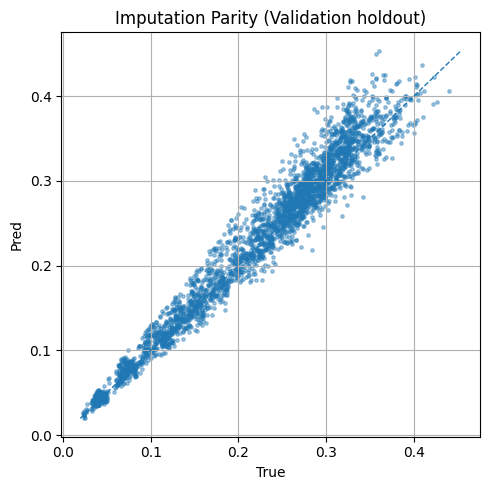

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_parity_test.png


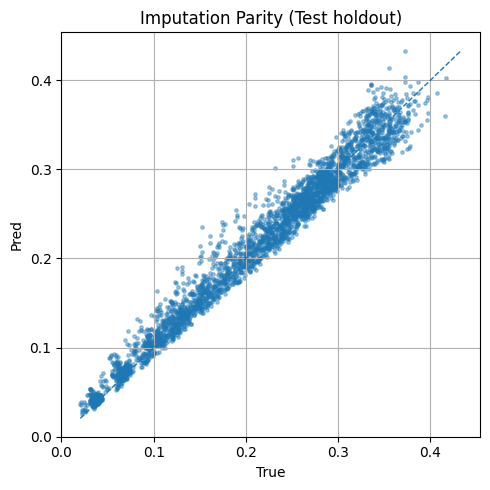

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_preview_1.png


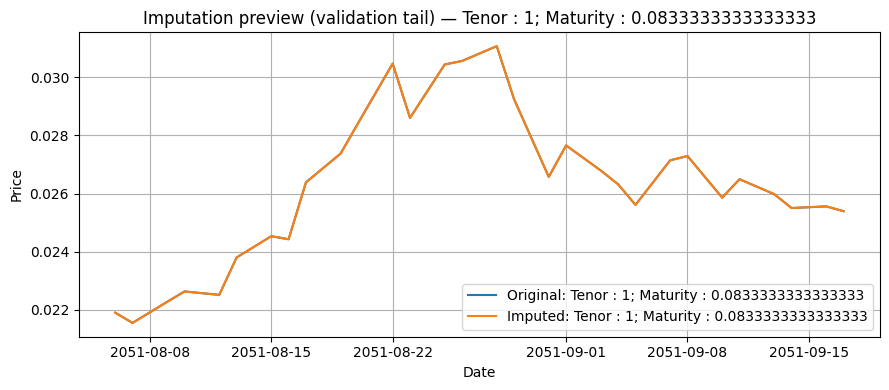

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_preview_2.png


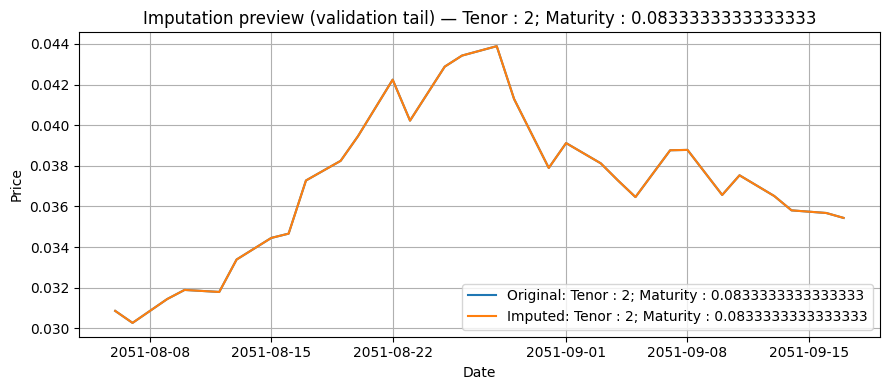

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_impute_preview_3.png


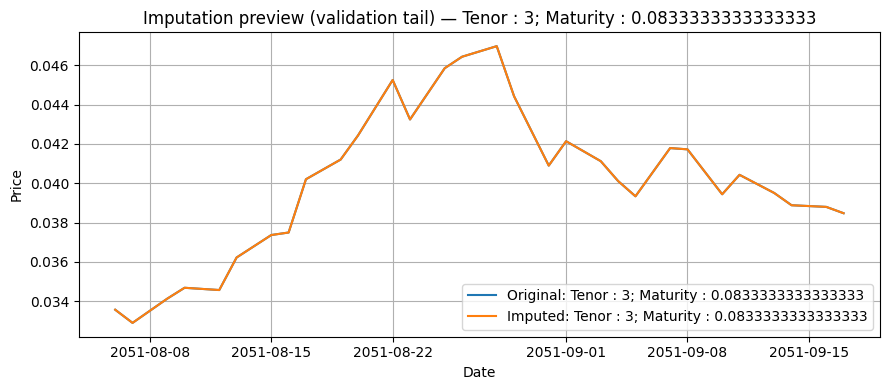

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\imputed_swaption_qrc.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_test_H14.png


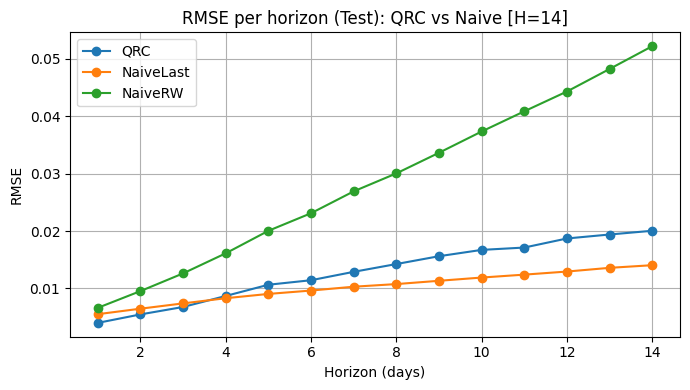

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_val_H14.png


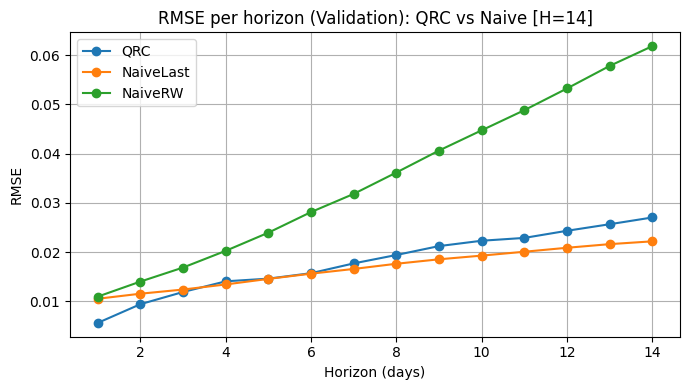

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_overlay_h1_H14.png


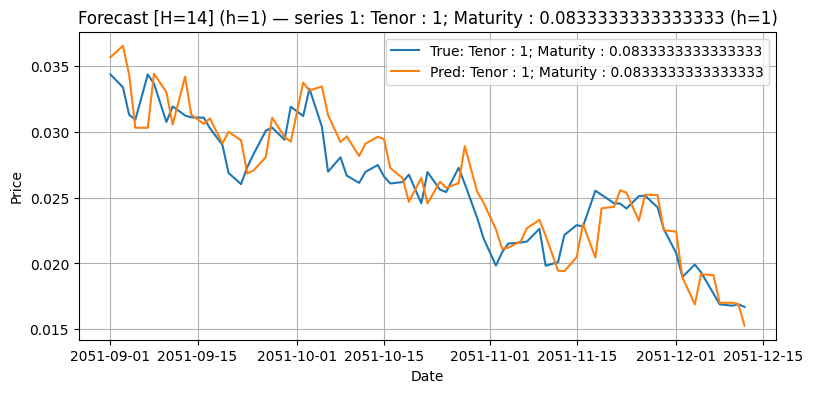

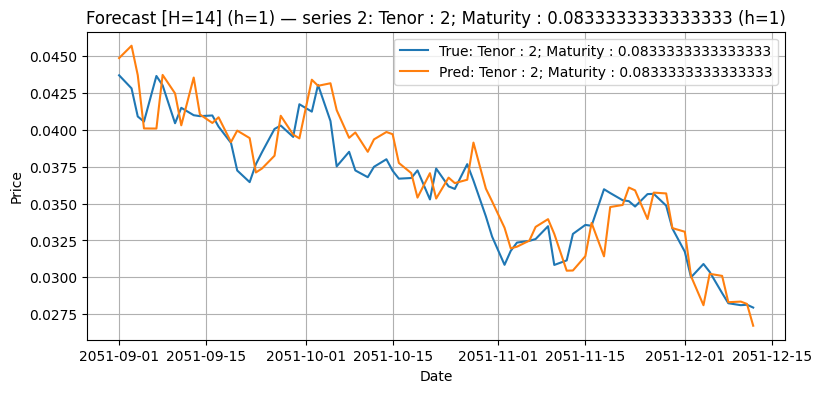

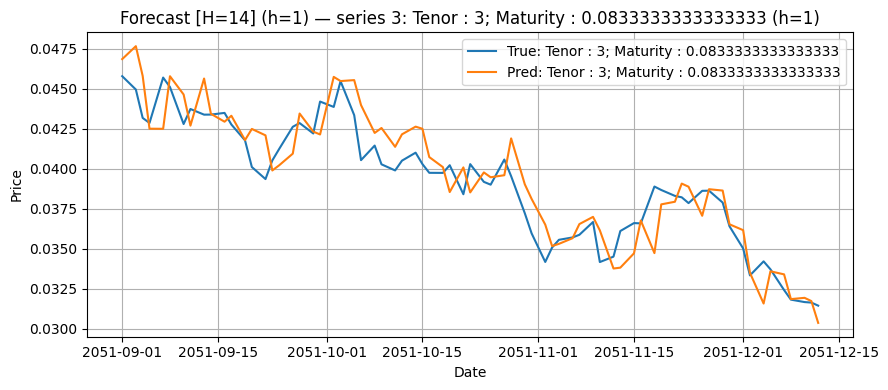

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_overlay_h14_H14.png


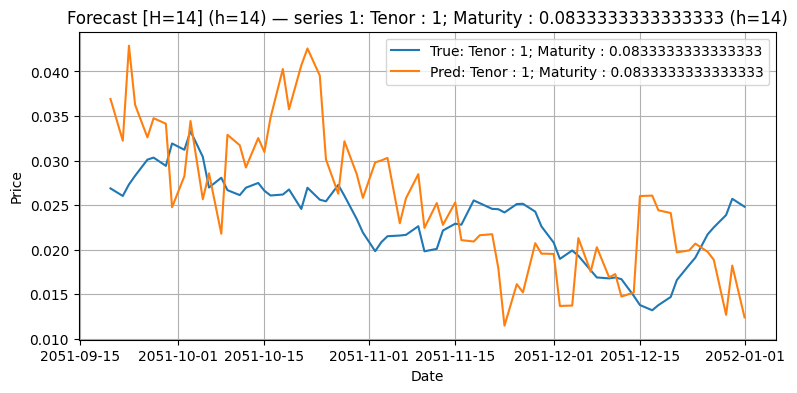

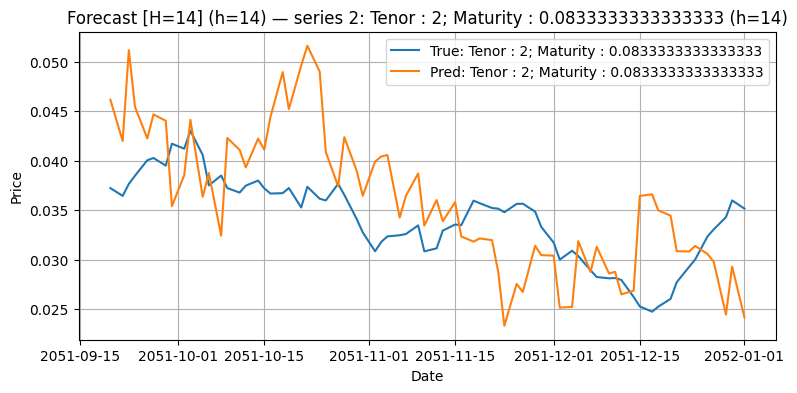

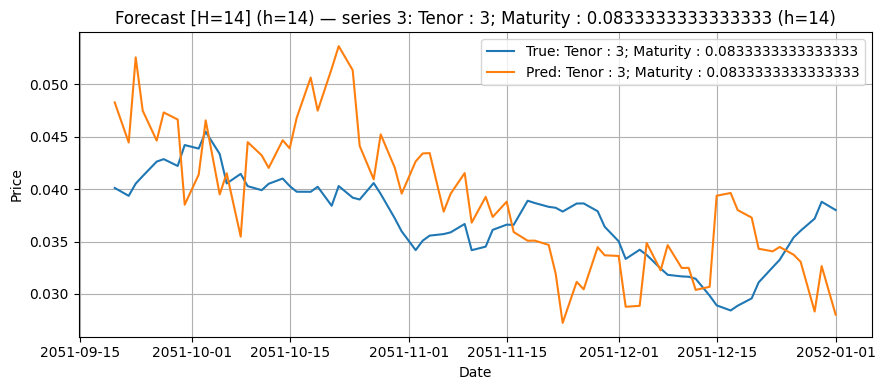

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_parity_h1_H14.png


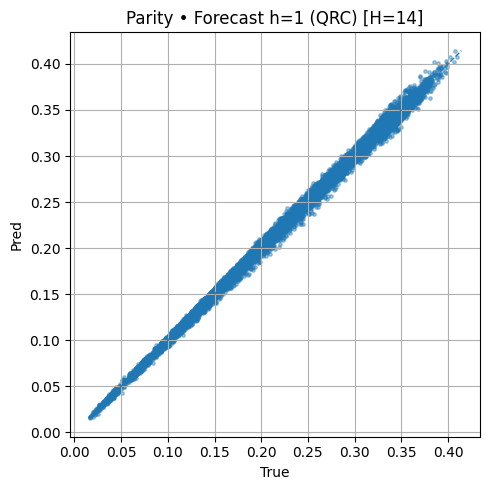

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_err_hist_h1_H14.png


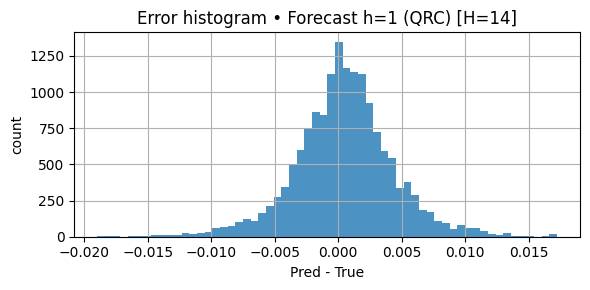

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_rmse_heatmap_h1_H14.png


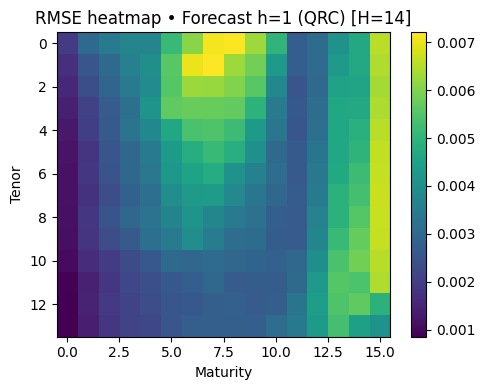

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_val_qrc_H14.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_val_naive_last_H14.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_val_naive_rw_H14.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_test_qrc_H14.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_test_naive_last_H14.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_test_naive_rw_H14.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_overlay_h1_H3.png


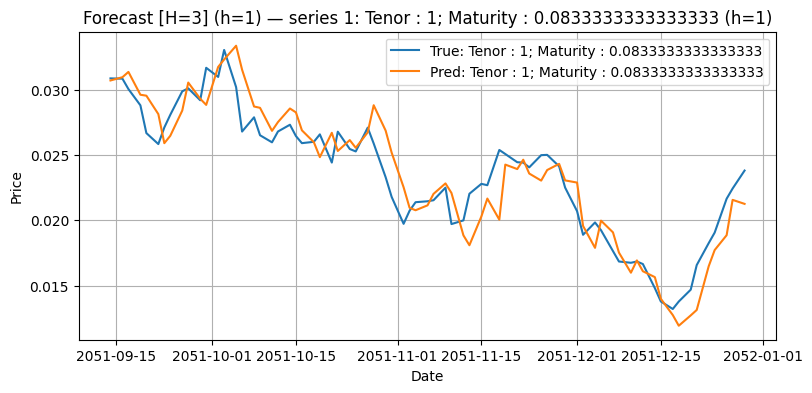

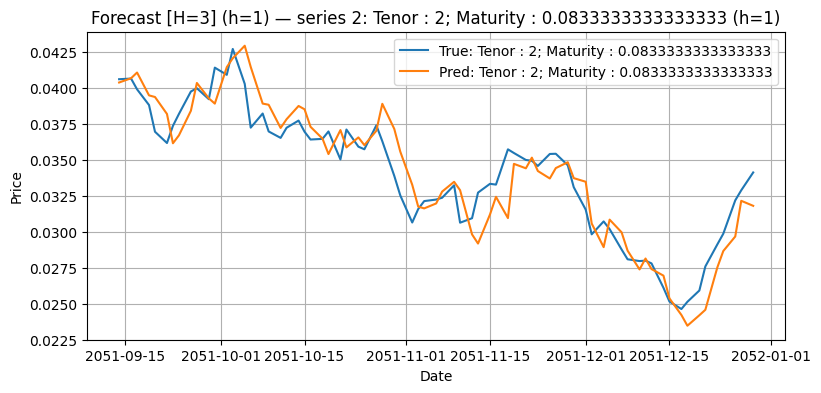

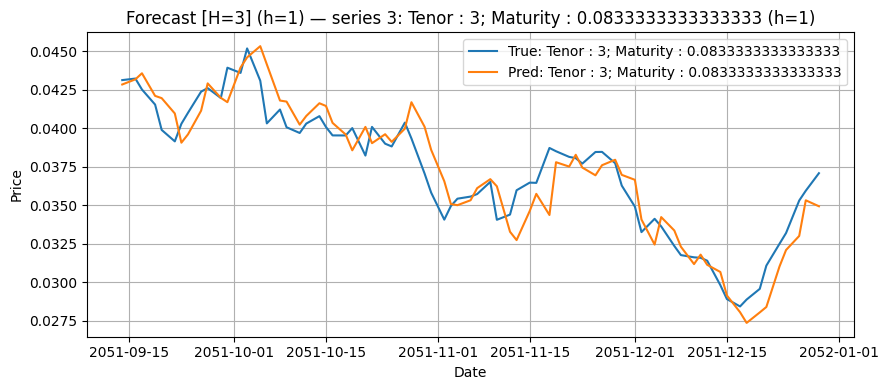

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_overlay_h3_H3.png


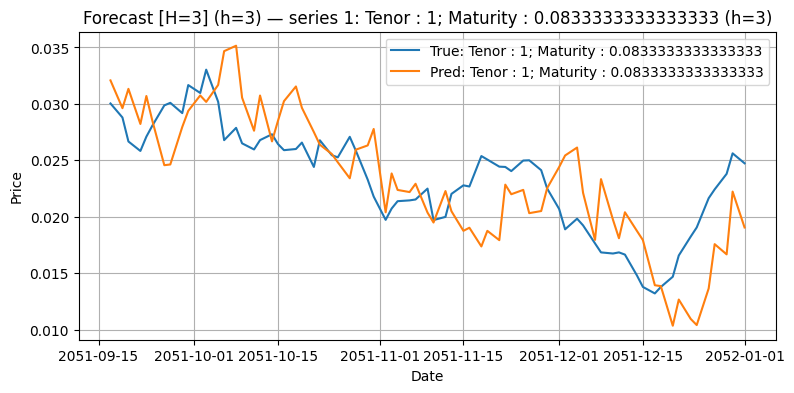

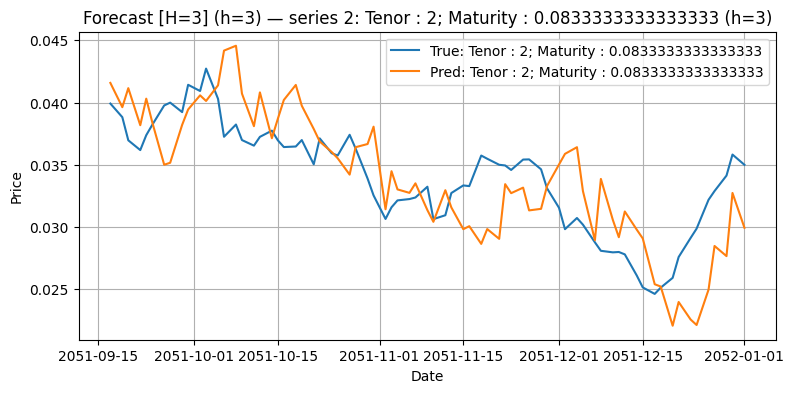

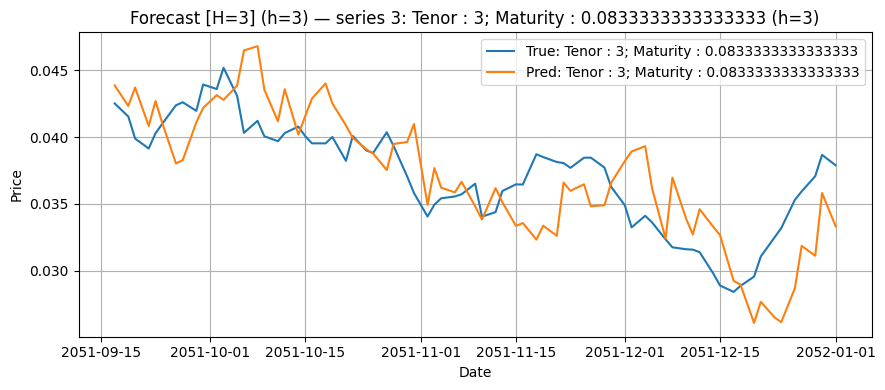

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_test_H3.png


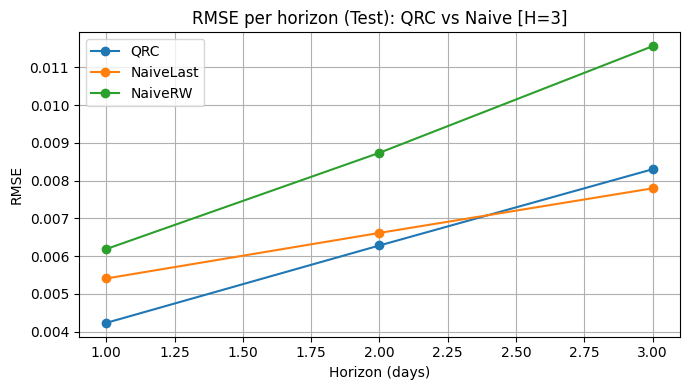

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_forecast_rmse_vs_h_val_H3.png


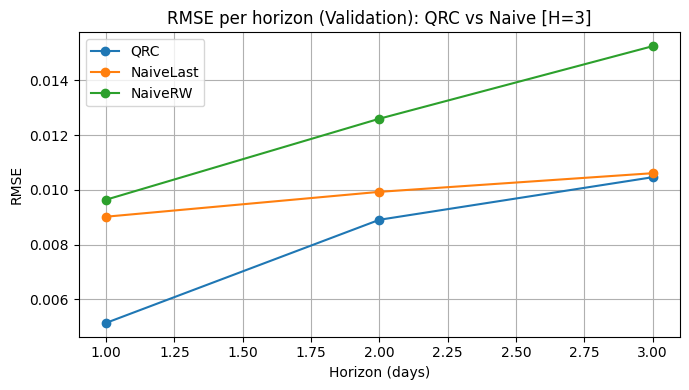

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_val_qrc_H3.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_val_naive_last_H3.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_val_naive_rw_H3.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_test_qrc_H3.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_test_naive_last_H3.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\table_test_naive_rw_H3.csv
[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_model_bar_H14.png


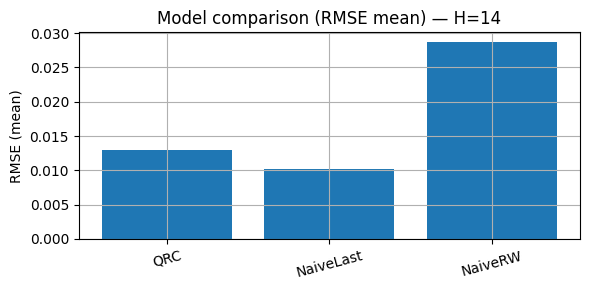

[SAVE] C:\qiskit-python\QFF2025\outputs\QRC\fig_model_bar_H3.png


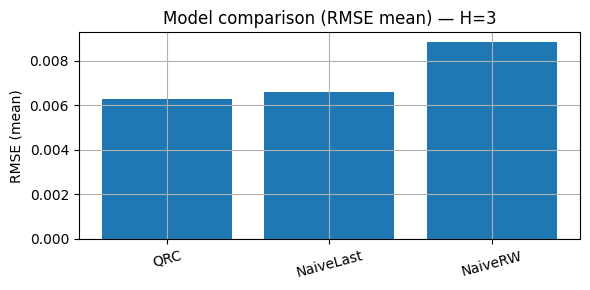


=== SUMMARY ===
Imputation: QRC vs Prev-day (RMSE, Test) = 0.016556 vs 0.003360
Forecast(H=14): Test RMSE mean — QRC=0.012983, Last=0.010260, RW=0.028685
Forecast(H=3):  Test RMSE mean — QRC=0.006273, Last=0.006607, RW=0.008829
[Note] qubits=6, depth=2, use_pair=False  （qubits=3 で高速化できます）


In [21]:
# ================================
# Cell 3 — 結果表示・保存（Imputation / Forecast[H=14,H=3]）
# ================================
outdir = OUTDIR

# ---------- A. 欠損補完（holdout評価と可視化） ----------
print("\n[A] Imputation — masked metrics")
print(f" Val  QRC  RMSE={ART_IMP['val_masked']['RMSE']:.6f} (n={ART_IMP['val_masked']['count']})")
print(f" Val  Prev RMSE={ART_IMP['val_masked_baseline']['RMSE']:.6f}")
print(f" Test QRC  RMSE={ART_IMP['test_masked']['RMSE']:.6f} (n={ART_IMP['test_masked']['count']})")
print(f" Test Prev RMSE={ART_IMP['test_masked_baseline']['RMSE']:.6f}")

# 1) holdout散布図（Val/Test）
parity_plot(ART_IMP["true_val_holdout"].reshape(-1,1), ART_IMP["pred_val_holdout"].reshape(-1,1),
            title="Imputation Parity (Validation holdout)")
savefig(os.path.join(outdir, "fig_impute_parity_val.png"))
parity_plot(ART_IMP["true_test_holdout"].reshape(-1,1), ART_IMP["pred_test_holdout"].reshape(-1,1),
            title="Imputation Parity (Test holdout)")
savefig(os.path.join(outdir, "fig_impute_parity_test.png"))

# 2) Val末尾30日のプレビュー（3系列）
val_dates = ART_IMP["dates_all"][ (W + ART_IMP["idx_val"].start) : (W + ART_IMP["idx_val"].stop) ]
dates_preview = val_dates[-30:]  # 末尾30
df_true_like = pd.DataFrame({"Date": pd.to_datetime(df[DATE_COL].values), **{c: df[c].values for c in ART_IMP["imputed_df"].columns if c!="Date"}})
df_imp_like  = ART_IMP["imputed_df"].copy()
for i in range(3):
    col = ART_IMP["imputed_df"].columns[1+i]
    plt.figure(figsize=(9,4))
    s1 = df_true_like.loc[df_true_like["Date"].isin(dates_preview)][col].values
    s2 = df_imp_like.loc[df_imp_like["Date"].isin(dates_preview)][col].values
    plt.plot(dates_preview, s1, label=f"Original: {col}")
    plt.plot(dates_preview, s2, label=f"Imputed: {col}")
    plt.title(f"Imputation preview (validation tail) — {col}")
    plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True)
    savefig(os.path.join(outdir, f"fig_impute_preview_{i+1}.png"))

# 完全補完CSV
ART_IMP["imputed_df"].to_csv(os.path.join(outdir, "imputed_swaption_qrc.csv"), index=False)
print(f"[SAVE] {os.path.join(outdir, 'imputed_swaption_qrc.csv')}")

# ---------- B. 2週間先予測（H=14） ----------
# 1) RMSE vs horizon（Val/Test）
plot_rmse_vs_h(ART_FC14["df_te"],  title="RMSE per horizon (Test): QRC vs Naive [H=14]")
savefig(os.path.join(outdir, "fig_forecast_rmse_vs_h_test_H14.png"))
plot_rmse_vs_h(ART_FC14["df_val"], title="RMSE per horizon (Validation): QRC vs Naive [H=14]")
savefig(os.path.join(outdir, "fig_forecast_rmse_vs_h_val_H14.png"))

# 2) h=1 と h=14 のオーバーレイ（3系列）
plot_forecast_overlay(ART_FC14["dates_by_h"], ART_FC14["true_te"], ART_FC14["pred_te"],
                      ART_FC14["feature_cols"], horizon_idx=0,  top_k=3, title_prefix="Forecast [H=14] (h=1)")
savefig(os.path.join(outdir, "fig_forecast_overlay_h1_H14.png"))
plot_forecast_overlay(ART_FC14["dates_by_h"], ART_FC14["true_te"], ART_FC14["pred_te"],
                      ART_FC14["feature_cols"], horizon_idx=13, top_k=3, title_prefix="Forecast [H=14] (h=14)")
savefig(os.path.join(outdir, "fig_forecast_overlay_h14_H14.png"))

# 3) Parity / Error hist / RMSE heatmap（h=1）
y_true_h1 = ART_FC14["true_te"][:, 0, :]
y_pred_h1 = ART_FC14["pred_te"][:, 0, :]
parity_plot(y_true_h1, y_pred_h1, title="Parity • Forecast h=1 (QRC) [H=14]")
savefig(os.path.join(outdir, "fig_parity_h1_H14.png"))
error_hist(y_true_h1, y_pred_h1, title="Error histogram • Forecast h=1 (QRC) [H=14]")
savefig(os.path.join(outdir, "fig_err_hist_h1_H14.png"))
rmse_heatmap_by_grid(y_true_h1, y_pred_h1, ART_FC14["feature_cols"], title="RMSE heatmap • Forecast h=1 (QRC) [H=14]")
savefig(os.path.join(outdir, "fig_rmse_heatmap_h1_H14.png"))

# 4) テーブル（Val/Test）
save_table(ART_FC14["df_val"]["QRC"],       os.path.join(outdir, "table_val_qrc_H14.csv"))
save_table(ART_FC14["df_val"]["NaiveLast"], os.path.join(outdir, "table_val_naive_last_H14.csv"))
save_table(ART_FC14["df_val"]["NaiveRW"],   os.path.join(outdir, "table_val_naive_rw_H14.csv"))
save_table(ART_FC14["df_te"]["QRC"],        os.path.join(outdir, "table_test_qrc_H14.csv"))
save_table(ART_FC14["df_te"]["NaiveLast"],  os.path.join(outdir, "table_test_naive_last_H14.csv"))
save_table(ART_FC14["df_te"]["NaiveRW"],    os.path.join(outdir, "table_test_naive_rw_H14.csv"))

# ---------- C. 3日先予測（H=3） ----------
# 1) オーバーレイ（h=1, h=3）
plot_forecast_overlay(ART_FC3["dates_by_h"], ART_FC3["true_te"], ART_FC3["pred_te"],
                      ART_FC3["feature_cols"], horizon_idx=0, top_k=3, title_prefix="Forecast [H=3] (h=1)")
savefig(os.path.join(outdir, "fig_forecast_overlay_h1_H3.png"))
plot_forecast_overlay(ART_FC3["dates_by_h"], ART_FC3["true_te"], ART_FC3["pred_te"],
                      ART_FC3["feature_cols"], horizon_idx=2, top_k=3, title_prefix="Forecast [H=3] (h=3)")
savefig(os.path.join(outdir, "fig_forecast_overlay_h3_H3.png"))

# 2) RMSE vs horizon（Val/Test）
plot_rmse_vs_h(ART_FC3["df_te"],  title="RMSE per horizon (Test): QRC vs Naive [H=3]")
savefig(os.path.join(outdir, "fig_forecast_rmse_vs_h_test_H3.png"))
plot_rmse_vs_h(ART_FC3["df_val"], title="RMSE per horizon (Validation): QRC vs Naive [H=3]")
savefig(os.path.join(outdir, "fig_forecast_rmse_vs_h_val_H3.png"))

# 3) テーブル（Val/Test）
save_table(ART_FC3["df_val"]["QRC"],       os.path.join(outdir, "table_val_qrc_H3.csv"))
save_table(ART_FC3["df_val"]["NaiveLast"], os.path.join(outdir, "table_val_naive_last_H3.csv"))
save_table(ART_FC3["df_val"]["NaiveRW"],   os.path.join(outdir, "table_val_naive_rw_H3.csv"))
save_table(ART_FC3["df_te"]["QRC"],        os.path.join(outdir, "table_test_qrc_H3.csv"))
save_table(ART_FC3["df_te"]["NaiveLast"],  os.path.join(outdir, "table_test_naive_last_H3.csv"))
save_table(ART_FC3["df_te"]["NaiveRW"],    os.path.join(outdir, "table_test_naive_rw_H3.csv"))

# ---------- D. モデル比較（棒グラフ：平均RMSE） ----------
plot_model_bar(ART_SUMMARY["H14"], title="Model comparison (RMSE mean) — H=14",
               out_png=os.path.join(outdir, "fig_model_bar_H14.png"))
plot_model_bar(ART_SUMMARY["H3"],  title="Model comparison (RMSE mean) — H=3",
               out_png=os.path.join(outdir, "fig_model_bar_H3.png"))

# ---------- E. サマリー ----------
print("\n=== SUMMARY ===")
print(f"Imputation: QRC vs Prev-day (RMSE, Test) = {ART_IMP['test_masked']['RMSE']:.6f} vs {ART_IMP['test_masked_baseline']['RMSE']:.6f}")
print(f"Forecast(H=14): Test RMSE mean — QRC={ART_FC14['df_te']['QRC']['RMSE'].mean():.6f}, "
      f"Last={ART_FC14['df_te']['NaiveLast']['RMSE'].mean():.6f}, RW={ART_FC14['df_te']['NaiveRW']['RMSE'].mean():.6f}")
print(f"Forecast(H=3):  Test RMSE mean — QRC={ART_FC3['df_te']['QRC']['RMSE'].mean():.6f}, "
      f"Last={ART_FC3['df_te']['NaiveLast']['RMSE'].mean():.6f}, RW={ART_FC3['df_te']['NaiveRW']['RMSE'].mean():.6f}")
print(f"[Note] qubits={N_QUBITS}, depth={DEPTH}, use_pair={USE_PAIR}  （qubits=3 で高速化できます）")
